In [16]:
import torchode as to
import torch
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt

In [17]:
class Model(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_features)
        )
    
    def forward(self, t, y):
        return self.layers(y) + torch.sin(t).unsqueeze(1) * 0.1 * y
    
n_features = 5
model = Model(n_features, 16)

In [18]:
batch_size = 16
n_steps = 2
y0 = torch.randn((batch_size, n_features))
t_eval = torch.linspace(0.0, 1.0, n_steps)

In [19]:
def score_fn_single(t, x):
    x = x.unsqueeze(0)  # Add batch dimension
    t = t.unsqueeze(0)  # Add batch dimension
    score = model(t, x)[0]  # Remove batch dimension
    return score, score

jac = torch.func.jacrev(score_fn_single, argnums=1, has_aux=True)
def divergence_and_score_fn(t, x):
    jacobian, score = jac(t, x)
    divergence = jacobian.trace()
    return divergence, score
divergence_and_score_fn_batched = torch.func.vmap(divergence_and_score_fn, in_dims=(0, 0), out_dims=(0, 0))

def batched_ode_fn(t, y):
    x, ll = y[..., :-1], y[..., -1]
    dll_dt, dx_dt = divergence_and_score_fn_batched(t, x) 
    return torch.cat((dx_dt, dll_dt.unsqueeze(-1)), dim=-1)

In [20]:
batch = 16
x = torch.randn((batch, n_features))
ll = torch.zeros((batch, 1))
y = torch.cat((x, ll), dim=-1)

In [21]:
term = to.ODETerm(batched_ode_fn)
step_method = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=1e-9, rtol=1e-7, term=term)
adjoint = to.AutoDiffAdjoint(step_method, step_size_controller)


In [22]:
problem = to.InitialValueProblem(y0=torch.cat((y0, torch.zeros(y0.shape[:-1] +  (1,))), dim=-1), t_eval=t_eval.repeat((batch_size, 1)))
sol = adjoint.solve(problem)

In [23]:
sol.ys.shape

torch.Size([16, 2, 6])

In [24]:
sol.stats

{'n_f_evals': tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]),
 'n_steps': tensor([7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 8, 7]),
 'n_accepted': tensor([7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 8, 7]),
 'n_initialized': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}

In [25]:
def jvp_test_func(x, t): 
    score = x**2 + t * 0.1 * x
    return score, score

def jvp_func(x, t, v):
    # For JVP, we need tangent for both inputs even if we only care about x
    jvp_result = torch.func.jvp(jvp_test_func, (x, t), (v, torch.zeros_like(t)), has_aux=True)
    return jvp_result

inp_x = torch.randn((batch_size, n_features))
inp_t = torch.randn((batch_size,1))
inp_v = torch.randn((batch_size, n_features))


analytical_jvp = (2*inp_x + 0.1 * inp_t) * inp_v  

print("JVP result:\n", jvp_func(inp_x, inp_t, inp_v))
print("Analytical JVP:", analytical_jvp)

JVP result:
 (tensor([[ 1.2310e-01,  2.2229e+00,  4.5351e-01,  2.2035e+00,  2.8455e+00],
        [ 1.5495e+00,  1.9315e+00,  4.5468e+00,  9.1079e-01,  5.2284e-01],
        [ 9.0228e-01,  5.9065e-01,  6.4095e-02,  1.3990e+00,  7.5136e-02],
        [ 4.3396e-02,  3.3990e+00,  2.3691e+00,  5.3033e-02,  1.2149e-02],
        [ 1.9063e+00,  2.9690e-01,  3.6899e-01,  8.4387e-02,  1.0655e+00],
        [-1.6644e-03,  1.1950e-01,  1.1891e-02,  2.7520e+00,  1.6789e-01],
        [ 5.4557e-02,  5.6812e-01,  1.1349e+00,  2.4905e-01,  7.4245e-02],
        [ 4.0568e-01,  4.1471e-01,  1.6619e-02,  7.2121e-03,  1.5193e-03],
        [ 9.8334e-02,  4.3123e-01,  6.5065e-03,  2.0811e+00,  2.8429e-01],
        [ 3.3600e-01,  8.2517e-03,  2.4117e-02,  1.5205e+00,  5.1825e+00],
        [ 1.2475e+00,  1.3740e-03,  7.6029e-01,  2.1147e-01,  4.4758e-02],
        [ 2.2828e-01, -7.5928e-04,  1.4330e+00,  3.9185e-01,  5.7271e-02],
        [ 1.0727e-01,  2.2136e+00,  1.7275e-01,  3.0031e-04,  8.9770e-01],
        [ 3

In [26]:
latents = torch.randn((batch_size, n_features))
sigma_max = 1.0  # Example value for sigma_max, adjust as needed
ll_priors = torch.distributions.Normal(0, sigma_max).log_prob(
    latents
).sum(dim=-1)

In [27]:
print(ll_priors.shape, ll_priors[0])

torch.Size([16]) tensor(-7.7077)


In [28]:
ll_priors_mvn = torch.distributions.MultivariateNormal(torch.zeros(latents.shape[-1]), sigma_max * torch.eye(latents.shape[-1])).log_prob(
    latents
)

In [29]:
print(ll_priors_mvn.shape, ll_priors_mvn[0])

torch.Size([16]) tensor(-7.7077)


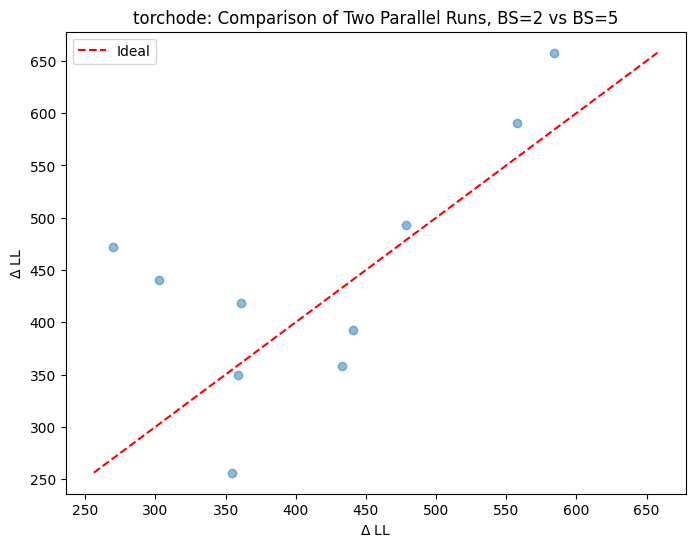

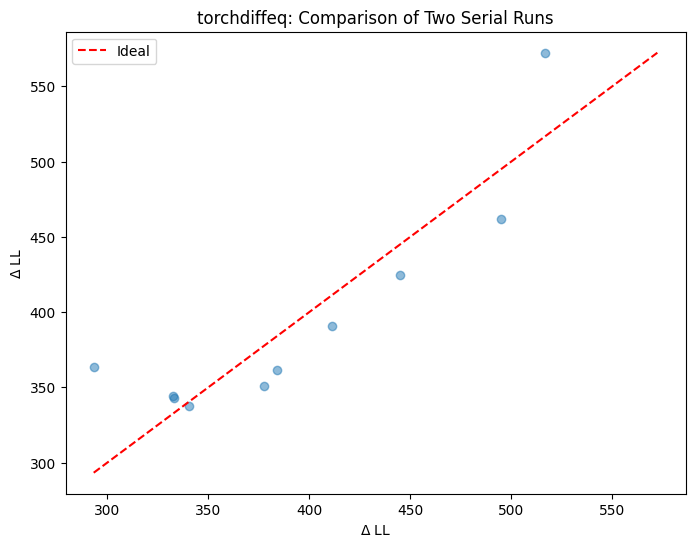

In [31]:
def compare_results(path_1, path_2, title="Comparison of Results"):
    p1_data = json.load(open(path_1, "r"))
    p2_data = json.load(open(path_2, "r"))
    fig, ax = plt.subplots(figsize=(8, 6))

    p1_keys = sorted(p1_data.keys())
    p2_keys = sorted(p2_data.keys())
    p1_values = [p1_data[key] for key in p1_keys]
    p2_values = [p2_data[key] for key in p2_keys]

    min_value = min(min(p1_values), min(p2_values))
    max_value = max(max(p1_values), max(p2_values))

    # make a scatter plot comparing the predicted delta_ll for bs2 and bs5
    ax.scatter(p1_values, p2_values, alpha=0.5)
    ax.set_xlabel(r"$\Delta$ LL")
    ax.set_ylabel(r"$\Delta$ LL")
    ax.set_title(title)
    ax.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Ideal')  # Diagonal line for reference
    ax.legend()
    plt.show()

compare_results(
    "/home/dunne/boltz-likelihoods/boltz_results_chignolin_ll_test_parallel_bs2/delta_ll.json",
    "/home/dunne/boltz-likelihoods/boltz_results_chignolin_ll_test_parallel_bs5/delta_ll.json",
    "torchode: Comparison of Two Parallel Runs, BS=2 vs BS=5"
)

compare_results(
    "/home/dunne/boltz-likelihoods/boltz_results_chignolin_ll_test_serial2/delta_ll.json",
    "/home/dunne/boltz-likelihoods/boltz_results_chignolin_ll_test_serial3/delta_ll.json",
    "torchdiffeq: Comparison of Two Serial Runs"
)

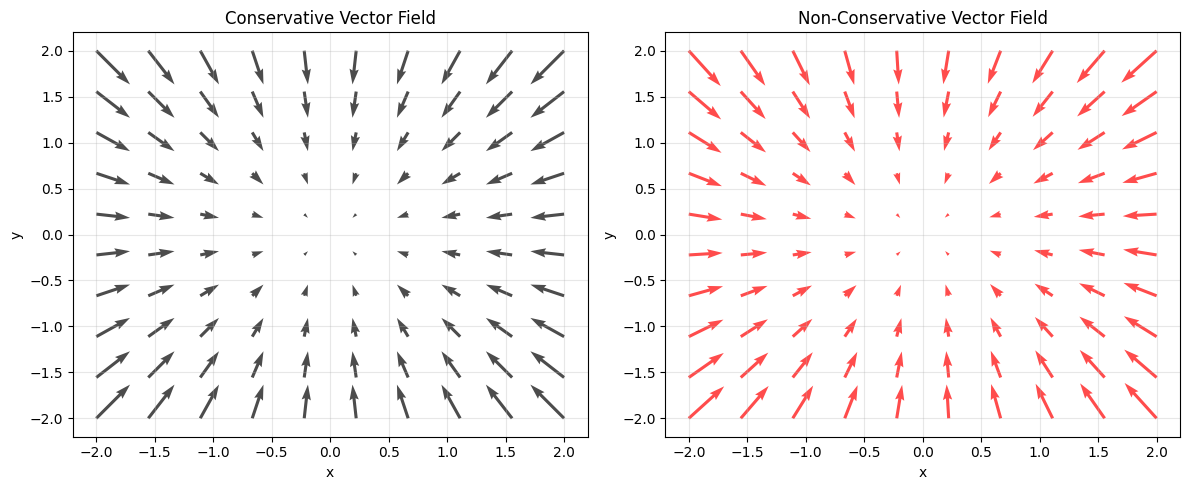

In [79]:
# look at two force fields R^2 -> R^2 where one is conservative and the other is non-conservative
epsilon = 0.1
conservative_score = lambda y: -2 * y # force for the potential U(x) = x^2 
nonconservative_score = lambda y: -2 * y + epsilon * torch.stack([-y[..., 1], y[..., 0]], dim=-1)

# make a plot of the two vector fields
# Create a grid of points for plotting the vector fields
x_range = torch.linspace(-2, 2, 10)
y_range = torch.linspace(-2, 2, 10)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
positions = torch.stack([X.flatten(), Y.flatten()], dim=1)

# Compute the vector fields
conservative_forces = torch.stack([conservative_score(pos) for pos in positions])
nonconservative_forces = torch.stack([nonconservative_score(pos) for pos in positions])

# Reshape for plotting
U_cons = conservative_forces[:, 0].reshape(X.shape)
V_cons = conservative_forces[:, 1].reshape(X.shape)
U_noncons = nonconservative_forces[:, 0].reshape(X.shape)
V_noncons = nonconservative_forces[:, 1].reshape(X.shape)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot conservative field
ax1.quiver(X, Y, U_cons, V_cons, alpha=0.7)
ax1.set_title('Conservative Vector Field')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, alpha=0.3)

# Plot non-conservative field
ax2.quiver(X, Y, U_noncons, V_noncons, alpha=0.7, color='red')
ax2.set_title('Non-Conservative Vector Field')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [96]:
# integrate the conservative vector field using torchode

def _score_fn_cons(x, t):
    score = - 2 * x/t
    return score, score
epsilon = 0.5
def _score_fn_noncons(x, t):
    score = (- 2 * x/t) + epsilon * torch.stack([-x[..., 1], x[..., 0]], dim=-1)
    return score, score

def solve_ode(_score_fn_single, current_batch_size=10):
    jac = torch.func.jacrev(_score_fn_single, argnums=0, has_aux=True)

    def divergence_and_score_fn_single(t, x):
        jacobian, score = jac(x, t)
        # jacobian shape is (n_atoms, 3, n_atoms, 3)
        # n_atoms = x.shape[0]
        # jacobian = jacobian.view(n_atoms * 3, n_atoms * 3)
        divergence = jacobian.trace()
        return divergence, score
    divergence_and_score_fn_batched = torch.func.vmap(divergence_and_score_fn_single, in_dims=(0, 0), out_dims=(0, 0))

    def ode_fn_batch(t_batch, x_and_ll, curr_batch_size):
        x = x_and_ll[:,:-1]  # Extract coordinates and leave the last feature (the log-likelihood)
        # x = x.view(curr_batch_size, -1, 3)  # Reshape to (batch_size, n_padded_atoms, 3)
        # centered_struct = x - x.mean(dim=1, keepdim=True)
        div_score, score = divergence_and_score_fn_batched(t_batch, x)
        score = score.view(curr_batch_size, -1)  # Reshape to (batch_size, n_padded_atoms * 3)
        update = (score * -t_batch.view(curr_batch_size, 1)).detach()
        dll_dt = (t_batch * div_score).detach()
        return torch.cat((update, dll_dt.unsqueeze(-1)), dim=-1)

    num_timepoints = 100  # Example number of time points
    batch_structs = 10*torch.randn((current_batch_size, 2))  # Example batch of structures
    t = torch.linspace(1,0.01, num_timepoints)  # 1D tensor with time points
    t_batched = t.unsqueeze(0).expand(current_batch_size, -1)  # (current_batch_size, 2)
    x_min_batch = torch.cat(
    (batch_structs,
    torch.zeros(current_batch_size, 1)),
    dim=-1
    ) # (current_batch_size, [n_padded_atoms * 3] + 1)


    # Solve ODE for entire batch
    term = to.ODETerm(ode_fn_batch, with_args=True)
    step_method = to.Dopri5(term=term)
    step_size_controller = to.IntegralController(atol=0.000001, rtol=0.001, term=term)
    adjoint = to.AutoDiffAdjoint(step_method, step_size_controller)
    # adjoint = torch.jit.script(adjoint)
    problem = to.InitialValueProblem(y0=x_min_batch, t_eval=t_batched)
    sol = adjoint.solve(problem, args=current_batch_size,)
    return sol

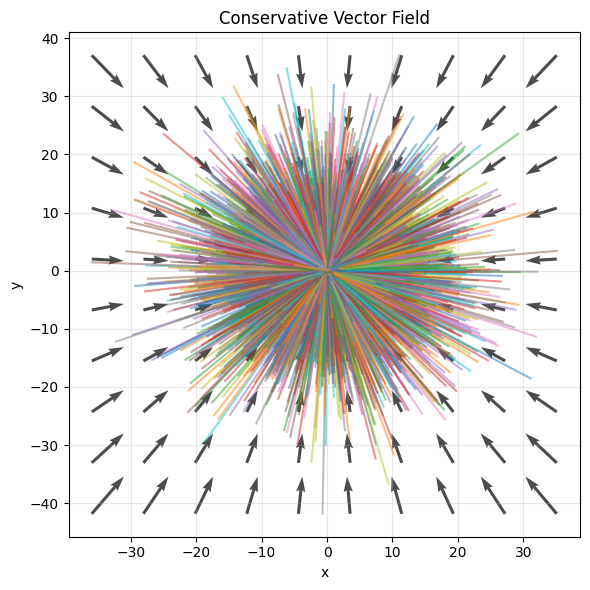

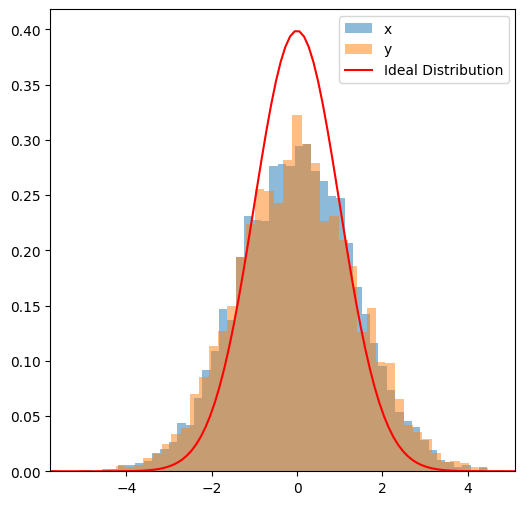

In [102]:
sol = solve_ode(_score_fn_cons, 5000)
xmin, xmax = sol.ys[:, :, 0].min().item(), sol.ys[:, :, 0].max().item()
ymin, ymax = sol.ys[:, :, 1].min().item(), sol.ys[:, :, 1].max().item()
x_range = torch.linspace(xmin, xmax, 10)
y_range = torch.linspace(ymin, ymax, 10)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
positions = torch.stack([X.flatten(), Y.flatten()], dim=1)

# Compute the vector fields
conservative_forces = torch.stack([conservative_score(pos) for pos in positions])
nonconservative_forces = torch.stack([nonconservative_score(pos) for pos in positions])

# Reshape for plotting
U_cons = conservative_forces[:, 0].reshape(X.shape)
V_cons = conservative_forces[:, 1].reshape(X.shape)
U_noncons = nonconservative_forces[:, 0].reshape(X.shape)
V_noncons = nonconservative_forces[:, 1].reshape(X.shape)

# Create subplots
fig, (ax1) = plt.subplots(figsize=(6, 6))

# Plot conservative field
ax1.quiver(X, Y, U_cons, V_cons, alpha=0.7)
ax1.set_title('Conservative Vector Field')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, alpha=0.3)

# Plot the trajectories from the ODE solution
for i in range(len(sol.ys)):
    traj = sol.ys[i].detach().cpu().numpy()
    ax1.plot(traj[:, 0], traj[:, 1], alpha=0.5)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(sol.ys[:, -1, 0].flatten().detach().cpu().numpy(), bins=50, density=True, alpha=0.5, label='x')
ax.hist(sol.ys[:, -1, 1].flatten().detach().cpu().numpy(), bins=50, density=True, alpha=0.5, label='y')
min_val = min(sol.ys[:, -1, 0].min().item(), sol.ys[:, -1, 1].min().item())
max_val = max(sol.ys[:, -1, 0].max().item(), sol.ys[:, -1, 1].max().item())
ax.set_xlim(min_val, max_val)
ideal_dist = torch.distributions.Normal(0, 1)
x_vals = torch.linspace(min_val, max_val, 100)
ax.plot(x_vals, ideal_dist.log_prob(x_vals).exp().numpy(), color='red', label='Ideal Distribution')
ax.legend()
plt.show()

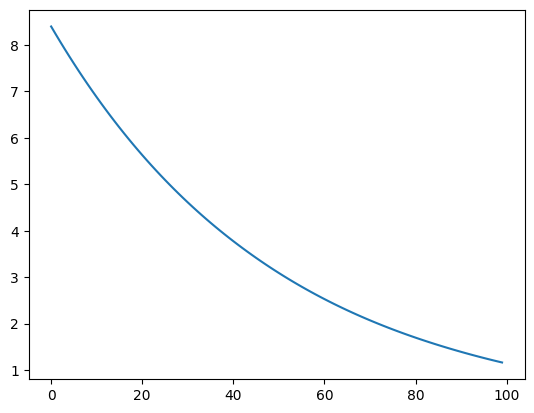

In [100]:
plt.plot(sol.ys[0,:, 0].detach().cpu().numpy())

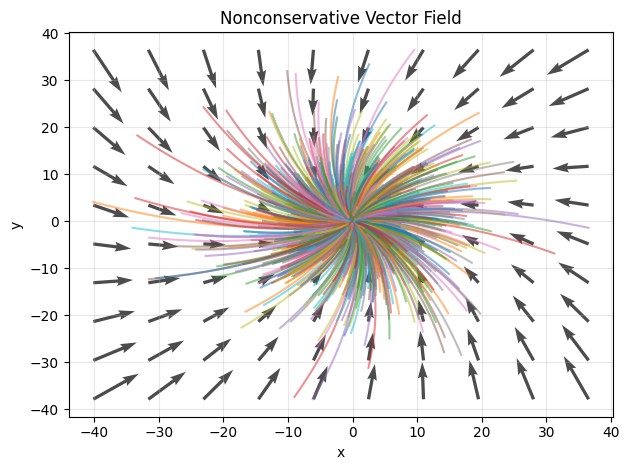

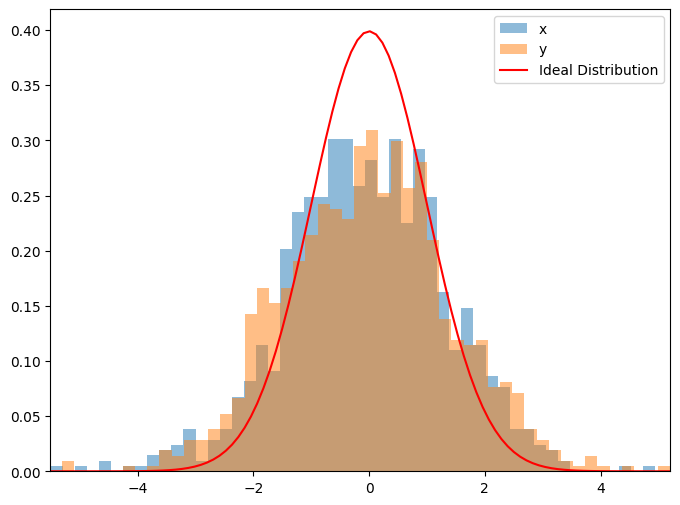

In [98]:
# make a plot of the two vector fields
# Create a grid of points for plotting the vector fields
sol = solve_ode(_score_fn_noncons, 1000)
xmin, xmax = sol.ys[:, :, 0].min().item(), sol.ys[:, :, 0].max().item()
ymin, ymax = sol.ys[:, :, 1].min().item(), sol.ys[:, :, 1].max().item()
x_range = torch.linspace(xmin, xmax, 10)
y_range = torch.linspace(ymin, ymax, 10)
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
positions = torch.stack([X.flatten(), Y.flatten()], dim=1)

# Compute the vector fields
conservative_forces = torch.stack([conservative_score(pos) for pos in positions])
nonconservative_forces = torch.stack([nonconservative_score(pos) for pos in positions])

# Reshape for plotting

U_noncons = nonconservative_forces[:, 0].reshape(X.shape)
V_noncons = nonconservative_forces[:, 1].reshape(X.shape)

# Create subplots
fig, (ax1) = plt.subplots()

# Plot conservative field
ax1.quiver(X, Y, U_noncons, V_noncons, alpha=0.7)
ax1.set_title('Nonconservative Vector Field')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, alpha=0.3)

# Plot the trajectories from the ODE solution
for i in range(len(sol.ys)):
    traj = sol.ys[i].detach().cpu().numpy()
    ax1.plot(traj[:, 0], traj[:, 1], alpha=0.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(sol.ys[:, -1, 0].flatten().detach().cpu().numpy(), bins=50, density=True, alpha=0.5, label='x')
ax.hist(sol.ys[:, -1, 1].flatten().detach().cpu().numpy(), bins=50, density=True, alpha=0.5, label='y')
min_val = min(sol.ys[:, -1, 0].min().item(), sol.ys[:, -1, 1].min().item())
max_val = max(sol.ys[:, -1, 0].max().item(), sol.ys[:, -1, 1].max().item())
ax.set_xlim(min_val, max_val)
ideal_dist = torch.distributions.Normal(0, 1)
x_vals = torch.linspace(min_val, max_val, 100)
ax.plot(x_vals, ideal_dist.log_prob(x_vals).exp().numpy(), color='red', label='Ideal Distribution')
ax.legend()
plt.show()